                            - DỰ ĐOÁN GIÁ CLOSE CHO TẬP DỮ LIỆU CTLT.csv

IMPORT THƯ VIỆN

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import array
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

ĐỌC DỮ LIỆU

In [17]:
# Đọc dữ liệu
stock_ctlt = pd.read_csv('../../Dataset/CTLT.csv')

# Column Date là object => đổi sang dạng datetime
stock_ctlt['Date'] = pd.to_datetime(stock_ctlt['Date'])

# Cho Cột Date làm giá trị index => in đc giá trị x là cột Date
stock_ctlt = stock_ctlt.set_index(pd.DatetimeIndex(stock_ctlt['Date'].values))

CHUẨN HÓA DỮ LIỆU

In [18]:
# Tạo dataframe mới chỉ chứa cột Date và giá trị Close
df_ctlt = pd.DataFrame(stock_ctlt, columns=['Date', 'Close'])

# Bỏ cột date khỏi dataframe
df_ctlt.drop('Date', axis=1, inplace=True)

In [19]:
scaler = MinMaxScaler(feature_range=(0,1))
df_ctlt = scaler.fit_transform(np.array(df_ctlt).reshape(-1,1))

CHIA CÁC TẬP DỮ LIỆU

In [20]:
# Tính độ dài
    # Train: 60%
    # Test: 20%
    # Val: 20%
train_size = int(len(df_ctlt) * 0.7)
test_size = int(len(df_ctlt) * 0.2)
val_size = len(df_ctlt) - train_size - test_size

In [21]:
# Lấy dữ liệu
train_data = df_ctlt[:train_size]
test_data = df_ctlt[train_size:train_size+test_size]
val_data = df_ctlt[train_size+test_size:]

In [22]:
# Tạo dataset cho X, Y train, test, val
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - time_step - 1):
		a = dataset[i:(i + time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [23]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
X_val, yval = create_dataset(val_data, time_step)

In [24]:
# Tạo input cho dữ liệu đầu vào LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] , 1)

HUẤN LUYỆN VÀ TRAIN MÔ HÌNH

In [25]:
# Định nghĩa mô hình
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape = (100, 1)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [26]:
# Sử dụng early stoping để dừng khi không có cải thiện
earlystop = EarlyStopping(monitor='val_loss', patience=10)

In [27]:
# Train mô hình
model.fit(X_train, y_train, validation_data=(X_test, ytest), epochs = 100, batch_size = 64,verbose = 1,  callbacks=earlystop)

Epoch 1/100
10/10 [==============================] - 38s 1s/step - loss: 0.1443 - val_loss: 0.0354
Epoch 2/100
10/10 [==============================] - 5s 503ms/step - loss: 0.0164 - val_loss: 0.0052
Epoch 3/100
10/10 [==============================] - 6s 625ms/step - loss: 0.0086 - val_loss: 0.0061
Epoch 4/100
10/10 [==============================] - 5s 549ms/step - loss: 0.0053 - val_loss: 0.0127
Epoch 5/100
10/10 [==============================] - 6s 618ms/step - loss: 0.0031 - val_loss: 0.0049
Epoch 6/100
10/10 [==============================] - 10s 987ms/step - loss: 0.0024 - val_loss: 0.0052
Epoch 7/100
10/10 [==============================] - 11s 1s/step - loss: 0.0023 - val_loss: 0.0058
Epoch 8/100
10/10 [==============================] - 7s 700ms/step - loss: 0.0022 - val_loss: 0.0070
Epoch 9/100
10/10 [==============================] - 5s 534ms/step - loss: 0.0022 - val_loss: 0.0057
Epoch 10/100
10/10 [==============================] - 4s 432ms/step - loss: 0.0021 - val_loss:

DỰ ĐOÁN TRÊN TẬP TEST VÀ TRAIN

In [28]:
# Dự đoán
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

1/1 [==============================] - 0s 135ms/step


TÍNH ĐỘ LỖI CỦA MÔ HÌNH

In [29]:
# Độ lỗi mô hình trên tập test
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = mean_absolute_percentage_error(y_pred, ytest)
test_mse = mean_squared_error(y_pred, ytest)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_pred, ytest)

print(f"Testing MAE: ", test_mae)
print(f"Testing MAPE: ", test_mape)
print(f"Testing MSE: ", test_mse)
print(f"Testing RMSE: ", test_rmse)
print(f"Testing MSLE: ", test_msle)

Testing MAE:  0.054404536707663834
Testing MAPE:  0.08470191075067836
Testing MSE:  0.0054195996090776665
Testing RMSE:  0.07361792994289955
Testing MSLE:  0.0021638734262106065


In [30]:
# Độ lỗi mô hình trên tập validation
val_mae = mean_absolute_error(y_pred_val, yval)
val_mape = mean_absolute_percentage_error(y_pred_val, yval)
val_mse = mean_squared_error(y_pred_val, yval)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_pred_val, yval)

print(f"Validation MAE: ",val_mae)
print(f"Validation MAPE: ", val_mape)
print(f"Validation MSE: ", val_mse)
print(f"Validation RMSE: ", val_rmse)
print(f"Validation MSLE: ", val_msle)

Validation MAE:  0.013775279996262624
Validation MAPE:  0.03940468338466353
Validation MSE:  0.00045319435105305536
Validation RMSE:  0.02128836186870787
Validation MSLE:  0.00024135088536583778


                                - DỰ ĐOÁN 30 NGÀY TIẾP THEO

In [31]:
x_input = val_data[5:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Khởi tạo giá trị chạy
i = 0

# List lưu trữ giá trị 30 ngày tiếp theo
prediction_next30_days = []

while(i < 30):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[-time_step:])

        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)

        temp_input.extend(y_hat[0].tolist())
        temp_input = temp_input[1:]

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose = 0)

        temp_input.extend(y_hat[0].tolist())

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1

In [32]:
# In ra giá trị dự đoán
print(prediction_next30_days)

[[0.356969952583313], [0.35947713255882263], [0.3617641031742096], [0.36382874846458435], [0.3656863570213318], [0.367362916469574], [0.3688894212245941], [0.37029701471328735], [0.3716146945953369], [0.37286800146102905], [0.3740772008895874], [0.3752584457397461], [0.37642329931259155], [0.3775801956653595], [0.37873464822769165], [0.3798898458480835], [0.38104772567749023], [0.3822091817855835], [0.3833742141723633], [0.38454270362854004], [0.3857143223285675], [0.38688844442367554], [0.38806453347206116], [0.38924267888069153], [0.39042213559150696], [0.3916029632091522], [0.39278483390808105], [0.39396780729293823], [0.3951517641544342], [0.39633655548095703]]


TRỰC QUAN HÓA TẤT CẢ DỮ LIỆU

In [33]:
# Lấy ra các ngày cuối cùng
last_date = stock_ctlt.index.max()
future_dates = pd.date_range(start=pd.to_datetime(last_date) + pd.DateOffset(days=1), periods=30, freq='D')

In [34]:
# Chuyển từ list thành dạng mảng
prediction_next30_days = np.array(prediction_next30_days)

# Chuyển đổi các giá trị trong đoạn 0 - 1 sang giá trị thực
prediction_next30_days = scaler.inverse_transform(prediction_next30_days).reshape(-1)

In [35]:
# Tạo dataframe chứa dữ liệu 30 ngày tới
future_data = pd.DataFrame({'Date': future_dates,
                            'Close': prediction_next30_days,
                            })
# Sắp xếp Date
future_data = future_data.sort_values(by='Date')

# Set index là Date
future_data.set_index('Date', inplace=True)

In [36]:
# Chuyển hóa dữ liệu lại như cũ
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)
val_data = scaler.inverse_transform(val_data)

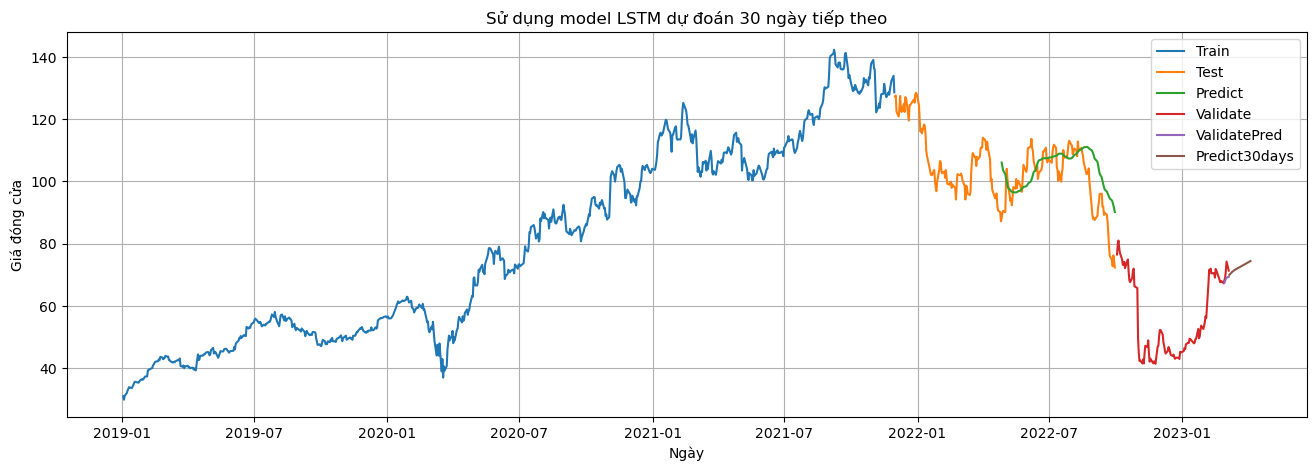

In [37]:
plt.figure(figsize=(16,5))

# Tập dữ liệu train
plt.plot(stock_ctlt.index[:train_size], train_data)

# Tập dữ liệu Test
plt.plot(stock_ctlt.index[train_size:train_size + test_size], test_data)

# Dữ liệu predict trên tập Test
plt.plot(stock_ctlt.index[train_size + time_step + 1: train_size + test_size],(y_pred))

# Tập dữ liệu Validate
plt.plot(stock_ctlt.index[train_size + test_size: train_size + test_size + val_size],val_data)

# Dữ liệu predict trên tập Validate
plt.plot(stock_ctlt.index[train_size + test_size + time_step + 1: train_size + test_size + val_size],y_pred_val)

# Dự đoán cho 30 ngày tiếp theo
plt.plot(future_data.index, future_data['Close'])

plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.title('Sử dụng model LSTM dự đoán 30 ngày tiếp theo')
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.grid()
plt.show()